# Incomplete Markets and Unemployment

Xiang Liu

Python

This file is finished under a lot a lot of help of Adam and Xing.  

4 (a). 

What is the natural borrowing limit for the worker?

We have the natural borrowing limit given by

$\phi = \frac{y_{min}}{r} = \frac{w l_{min}}{r} = \frac{0.5}{r} = 1/2r$.

## Initial setup 

In [61]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=120)
import numba as nb
import time

## Parameters and grids

In [62]:
beta= 0.95
bigR = 1.04   # gross interest rate
rho = 2
alpha = 0.36
delta = 0.1
phi = 0
w = 1
n = 2         # number of endowment shocks
p = np.array([[.5, .5], 
              [0.2, 0.8]])  # transition probability for the endowment shocks
l_g = np.array([0.5, 1.0]) # endowment shocks
y_g = w * l_g

ytilde_g = y_g - (bigR - 1) * phi

grid_points = 10000 # for the asset holdings 
ahat_max = 15  # this is just a guess
ahat_min = 0
ahat_g = np.linspace(ahat_min, ahat_max, grid_points) # grid for ahat

## Solving the HH problem

The household problem takes the recursive form:

$V(x, s) = \max_{a\geq -\phi} u(x - a) + \beta E[V(Ra + w l(s'))]$

Define $\hat{a} = a + \phi$, $\hat{x} = x + \phi$, the household problem can be rewritten as

$v(\hat{x}, s) = \max_{\hat{a} \geq 0} u(\hat{x} - \hat{a}) + \beta E[v(R\hat{a} + w l(s') - (R - 1) \phi)]$

For simplicity, we define $\tilde{y}$ such that $v(\hat{x}, s) = \max_{\hat{a} \geq 0} u(\hat{x} - \hat{a}) + \beta E[v(R\hat{a} + \tilde{y}(s'))]$.

Note that we construct grids using $\hat{a}$ and $\hat{a'}$, and $v(\hat{x}, s) = v(R\hat{a} + y(s))$.

The following function (iterate_value) compues the value function and the policy function from the HH problem. It is smarter than brute force value function iteration as it exploits that the policy function is monotonic and the the problem is concave. 

In [63]:
@nb.jit
def u1(c):
    return c ** (1 - rho) / (1 - rho) 

@nb.jit
def iterate_value(v_0, bigR, ytilde_g, u, tolerance=10**(-4)):
    v_1 = np.empty((grid_points, n))
    pol_1 = np.empty((grid_points, n), dtype=np.int32)
    p_transpose = p.transpose()
    beta_v_exp = np.empty((grid_points, n))
    iter = 0
    while True:
        distance = 0.0
        iter += 1
        for s in range(n):  # pre-computing the expected value term
            for i in range(grid_points):
                accum = 0.0
                for sprime in range(n):
                    accum = accum + beta * p[s, sprime] * v_0[i, sprime]
                beta_v_exp[i, s] = accum
        for s in range(n):  # doing the optimization
            pol = 0
            for i in range(grid_points):
                just_started = True
                j = pol # policy is monotonic -- start from the previous optimal policy
                while j < grid_points:
                    c = bigR * ahat_g[i] + ytilde_g[s] - ahat_g[j]
                    if c > 0.0:
                        temp = u(c) + beta_v_exp[j, s]
                        if just_started:
                            vmax = temp
                            pol = j
                            just_started = False
                        elif temp > vmax:
                            vmax = temp
                            pol = j
                        else:
                            # value decreased -- concavity means it can't go up again
                            break
                    j += 1
                v_1[i, s] = vmax
                pol_1[i, s] = pol
                dis = abs(vmax - v_0[i, s])
                if dis > distance: 
                    distance = dis
        if distance < tolerance:
            break
        else:
            temp2 = v_0
            v_0 = v_1
            v_1 = temp2
    return v_1, pol_1

### Computing the solution to the HH's problem

In [64]:
v_0 = np.zeros((grid_points, n))
t = time.time()
value, policy = iterate_value(v_0, bigR, ytilde_g, u1)
print(' {} seconds'.format(time.time() - t))

 0.45414018630981445 seconds


4 (b). 

Describe the code. How is the program attaining the results? How is the optimization of the HH value function done? Explain in detail.

The code above (iterate_value) computes the value function and the policy function from the HH problem. The code takes input with a value function (the "guess" we make), interest rate, income, and tolerance. The function then loops until convergence.

(  i) In each step, it starts by pre-computing the expected value term, using the value function that was used as input.

( ii) The function iterates over shocks, then, over starting assets. We know that the policy function is monotonic within a shock, the starting guess for optimal assets starts at the previous state variable’s optimal assets.

(iii) The function then loops through all possible options for next period’s assets. It ends until either reaches the end, or the utility drops between loops which indicates optimality. This is because of that concave utility means that the utility can’t increase for a higher choice of future assets.

( iv) The policy function and value function are computed based on convergence satisfies the tolerance we set.

Overall, the code solves the household problem using value function iteration, the problem can be done in this way since it has a recursive formulation and a functional form for the utility function to compute the optimal value functions and policy functions. 

4(c). 

The code will plot the transition mapping of “cash in hands”. You will see two plots (one for each employment state). In addition, you should plot the optimal policy function for assets and consumption (both as a function of “cash in hands” and again, a plot per state). In which state (employed or unemployed) is the worker saving more for a given amount of cash in hands? Why is that?

The worker saves more when they are employed. Employed workers have more assets, so they can save more and reduce consumption for current period to have higher consumption for next period to smooth spending over periods. 

See codes below for plots. 

### Plotting the Transition maps 

Because the state matters now (the shocks are not iid), we have two plots for the transition map of Aiyagari (one for each idiosyncratic state)

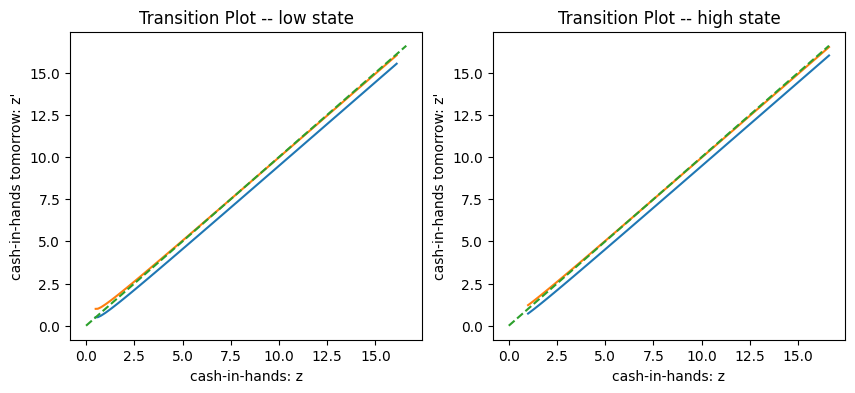

In [65]:
plt.figure(figsize=(10, 4))
for plot_i, label in ((0, 'low'), (1, 'high')):
    plt.subplot(121 + plot_i)
    plt.title("Transition Plot -- " + label + " state")
    state = plot_i
    zmax = bigR * ahat_max + max(y_g)
    for s in range(n):
        plt.plot(
            [bigR * ahat_g[i] + ytilde_g[state] for i in range(grid_points)],
            [bigR * ahat_g[policy[i, state]] + ytilde_g[s] for i in range(grid_points)])
    plt.plot((0, zmax), (0, zmax), '--')
    plt.ylabel("cash-in-hands tomorrow: z'")
    plt.xlabel("cash-in-hands: z")

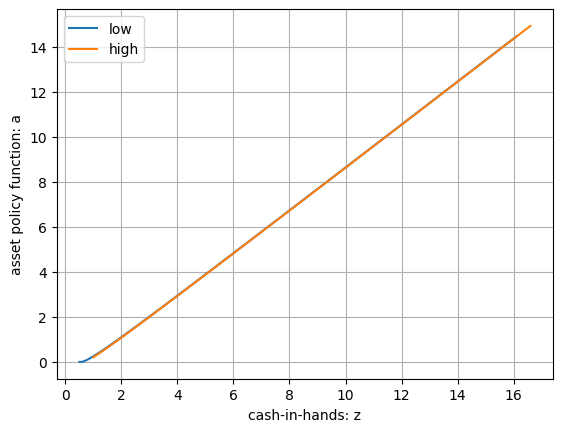

In [66]:
## plot 
for plot_i, label in ((0, 'low'), (1, 'high')):
    state = plot_i
    zmax = bigR * ahat_max + max(y_g)
    plt.plot(
        [bigR * ahat_g[i] + ytilde_g[state] for i in range(grid_points)],
        [ahat_g[policy[i, state]] for i in range(grid_points)], label=label)
plt.ylabel("asset policy function: a")
plt.xlabel("cash-in-hands: z")
plt.legend()
plt.grid()
# plt.gcf().set_dpi(300)

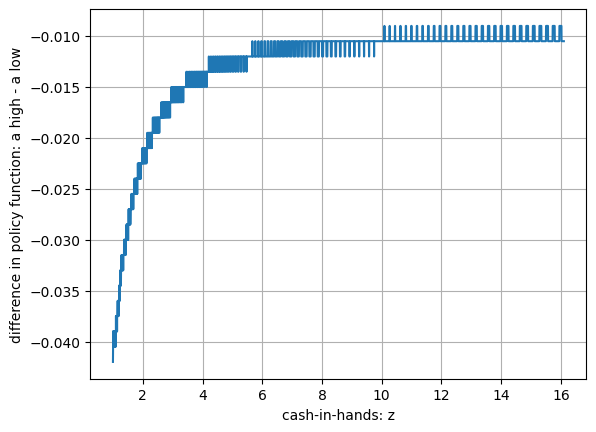

In [67]:
## Here, compare asset policy functions (over comparable cash-in-hands)


cih_low = np.array([bigR * ahat_g[i] + ytilde_g[0] for i in range(grid_points)])[321:]
a_prime_low = np.array([ahat_g[policy[i, 0]] for i in range(grid_points)])[321:]
cih_high = np.array([bigR * ahat_g[i] + ytilde_g[1] for i in range(grid_points)])[: -321]
a_prime_high = np.array([ahat_g[policy[i, 1]] for i in range(grid_points)])[: -321]
# cih_low and cih_high are approximately equal

plt.plot(cih_low, a_prime_high - a_prime_low)
plt.ylabel("difference in policy function: a high - a low")
plt.xlabel("cash-in-hands: z")
plt.grid()

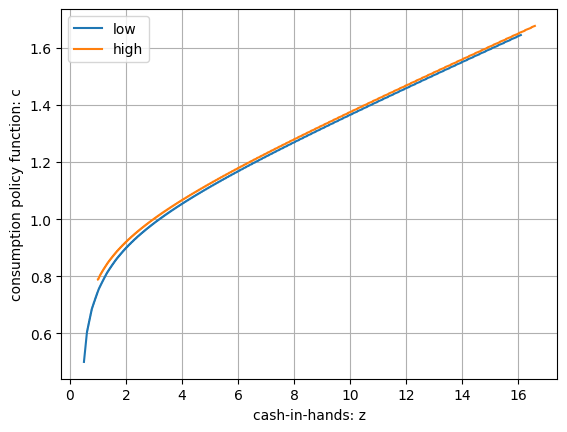

In [68]:
for plot_i, label in ((0, 'low'), (1, 'high')):
    state = plot_i
    zmax = bigR * ahat_max + max(y_g)
    plt.plot(
        [bigR * ahat_g[i] + ytilde_g[state] for i in range(grid_points)],
        [bigR * ahat_g[i] + ytilde_g[state] - ahat_g[policy[i, state]] for i in range(grid_points)], label=label)
plt.ylabel("consumption policy function: c")
plt.xlabel("cash-in-hands: z")
plt.legend()
plt.grid()
# plt.gcf().set_dpi(300)

A note here, one can detrend these plots to have a better understanding of what's going on since the curves we have there are so close to each other. Adam did that, super cool! 

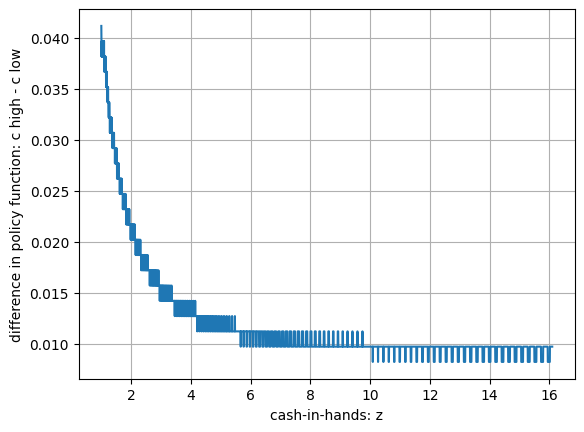

In [69]:
## Here, compare consumption policy functions (over comparable cash-in-hands)


cih_low = np.array([bigR * ahat_g[i] + ytilde_g[0] for i in range(grid_points)])[321:]
c_low = np.array([bigR * ahat_g[i] + ytilde_g[0] - ahat_g[policy[i, 0]] for i in range(grid_points)])[321:]
cih_high = np.array([bigR * ahat_g[i] + ytilde_g[1] for i in range(grid_points)])[: -321]
c_high = np.array([bigR * ahat_g[i] + ytilde_g[1] - ahat_g[policy[i, 1]] for i in range(grid_points)])[: -321]
# cih_low and cih_high are approximately equal

plt.plot(cih_low, c_high - c_low)
plt.ylabel("difference in policy function: c high - c low")
plt.xlabel("cash-in-hands: z")
plt.grid()

## The stationary distribution 

The following function takes an initial pdf and iterates using the policy function to obtain the stationary distribution 

In [70]:
@nb.jit
def get_stationary_distribution(pdf_0, policy, tolerance=10**(-7)):
    while True:
        pdf_1 = np.zeros((grid_points, n))
        for i in range(grid_points):
            for s in range(n):
                for sprime in range(n):
                    pdf_1[policy[i, s], sprime] += p[s, sprime] * pdf_0[i, s]
        distance = 0.0
        for i in range(grid_points):
            for s in range(n):
                distance = max(abs(pdf_1[i, s] - pdf_0[i, s]), distance)
        if distance - tolerance < 0:
            break
        else:
            pdf_0 = pdf_1
    return pdf_1

### Computing the stationary distribution

In [71]:
pdf_0 = np.ones((grid_points, n)) / (grid_points * n)
t = time.time()
pdf_ss = get_stationary_distribution(pdf_0, policy)
print(' {} seconds'.format(time.time() - t))

 0.1923389434814453 seconds


### Plotting the Stationary distribution over assets

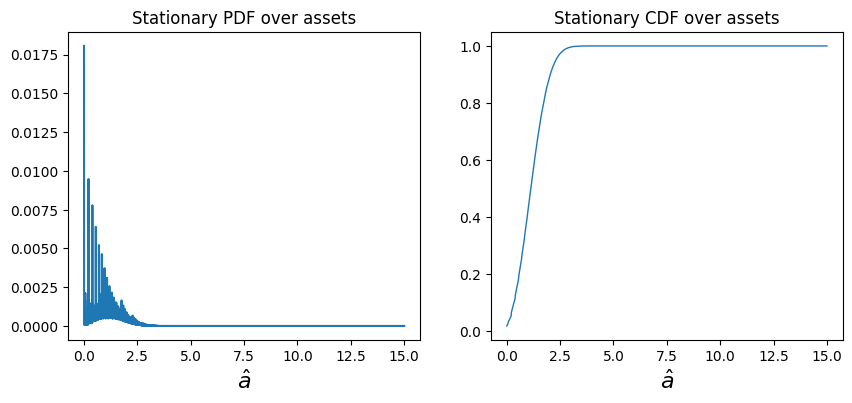

In [72]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
pdf_assets = np.zeros((grid_points))
for i in range(grid_points):
    pdf_assets[i] = np.sum(pdf_ss[i, :])
plt.plot(ahat_g, pdf_assets)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary PDF over assets');

plt.subplot(122)
plt.plot(ahat_g, np.cumsum(pdf_assets), lw = 1)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary CDF over assets');

4 (d).

In [73]:
K_104 = np.sum(ahat_g * pdf_assets)
K_104

1.169336123898077

4 (e).

In [74]:
pdf_assets[0]

0.018057194131074747

4 (f).

 0.5688340663909912 seconds
 0.008268117904663086 seconds


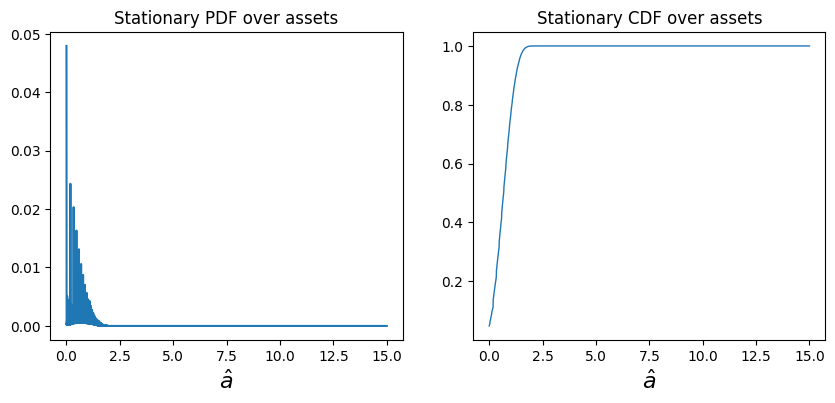

In [75]:
@nb.jit
def u2(c):
    return np.log(c)

v_0 = np.zeros((grid_points, n))
t = time.time()
value2, policy2 = iterate_value(v_0, bigR, ytilde_g, u2)
print(' {} seconds'.format(time.time() - t))

pdf_0 = np.ones((grid_points, n)) / (grid_points * n)
t = time.time()
pdf_ss = get_stationary_distribution(pdf_0, policy2)
print(' {} seconds'.format(time.time() - t))

plt.figure(figsize=(10, 4))
plt.subplot(121)
pdf_assets = np.zeros((grid_points)) 
for i in range(grid_points):
        pdf_assets[i] = np.sum(pdf_ss[i, :])
plt.plot(ahat_g, pdf_assets)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary PDF over assets');

plt.subplot(122)
plt.plot(ahat_g, np.cumsum(pdf_assets), lw = 1)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary CDF over assets');

4 (g).

In [76]:
pi0 = pdf_ss.sum(axis=0)
L_ss = np.sum(pi0 * l_g)
pi0

array([0.28571429, 0.71428571])

4 (h). 

Using that $F = Ak^{\alpha}l^{1-\alpha}$ where $\alpha = 0.36$, and that the annual depreciation rate of $k$ equals $\delta = 0.1$, solve for the functions $W(R)$ and $K(R)$. Use the fact that $w(R) = 1$ for $R = 1.04$ to back out the value of $A$ in the production function.


During the lecture, we have 
$$
\begin{aligned}
& R=F_{k}(K, L)+(1-\delta) \\
& w=F_{l}(K, L) .
\end{aligned}
$$

Since we have given that $F=A k^{\alpha} l^{1-\alpha}$, we get

$$
\begin{aligned}
& R=\alpha A k^{\alpha-1} l^{1-\alpha}+(1-\delta) \\
& w=(1-\alpha) A k^{\alpha} l^{-\alpha} .
\end{aligned}
$$

We have computed the partial equilibrium for $w=1$ and $R=1.04$. Then, we can solve for $A$ in terms of $k_{1.04}$ and $l_{1.04}$. See

$$
\begin{aligned}
& 1=(1-\alpha) A k_{1.04}^{\alpha} l_{1.04}^{-\alpha} \\
& \Leftrightarrow A=\frac{1}{1-\alpha} k_{1.04}^{-\alpha} 4_{1.04}^{\alpha} .
\end{aligned}
$$

Thenm, for $K(R)$, we have 

$$
\begin{aligned}
& R=\alpha A k_{R}^{\alpha-1} l_{R}^{1-\alpha}+(1-\delta) \\
& \Leftrightarrow \alpha A k_{R}^{\alpha-1} l_{R}^{1-\alpha}=R-(1-\delta) \\
& \Leftrightarrow \alpha \frac{1}{1-\alpha} k_{1.04}^{-\alpha} l_{1.04}^{\alpha} k_{R}^{\alpha-1} l_{R}^{1-\alpha}=R-(1-\delta) \\
& \Leftrightarrow \frac{\alpha}{1-\alpha} \frac{k_{1.04}^{-\alpha} l_{1.04}^{\alpha} l_{R}^{1-\alpha}}{R-(1-\delta)}=k_{R}^{1-\alpha} .
\end{aligned}
$$

We have $l_{R}=l_{1.04}=l_{s s}=0.857$, thus, it follows that

$$
\begin{aligned}
& \Leftrightarrow k_{R}^{1-\alpha}=\frac{\alpha}{1-\alpha} \frac{k_{1.04}^{-\alpha} l_{s s}}{R-(1-\delta)} \\
& \Leftrightarrow K(R)=\left(\frac{\alpha}{1-\alpha} \frac{k_{1.04}^{-\alpha} l_{s s}}{R-(1-\delta)}\right)^{\frac{1}{1-\alpha}} .
\end{aligned}
$$

Now, $W(R)$ is given by:

$$
\begin{aligned}
W(R) & =(1-\alpha) A k_{R}^{\alpha} l_{R}^{-\alpha} \\
& =(1-\alpha) \frac{1}{1-\alpha} k_{1.04}^{-\alpha} l_{1.04}^{\alpha} k_{R}^{\alpha} l_{s s}^{-\alpha} \\
& =k_{1.04}^{-\alpha} K(R)^{\alpha},
\end{aligned}
$$

in the equation above, we used the fact that $l_{1.04}=l_{s s}=0.857$.

4 (i).

Do we have a stationary general equilibrium for the interest rate R assumed?

In [77]:
def K_R(R, A):
    return ((alpha / (1 - alpha)) * (A ** (-alpha) * L_ss) / (R - (1 - delta))) ** (1 / (1 - alpha))

def W_R(A, K_R):
    return (K_R / A) ** alpha

K_104104 = K_R(bigR, K_104)
W_104 = W_R(K_104, K_104104)

print(f'Change in K_104: {abs(K_104104 - K_104)}')
print(f'Change in W_104: {abs(W_104 - 1)}')

Change in K_104: 5.153634148253412
Change in W_104: 0.8360032197654617


We don't have a stationary general equilibrium, which we can see by plugging values into the equations derived in (h) and seeing if they are fixed points, but they are not fixed pionts as shown in the code above. 

4 (j).

Create a grid for R from 1.04 to 1.05 (say with 20 points). Do Aiyagari’s $\bar{A}(R) = K(R)$ plot. Identify the stationary general equilibrium.

In [78]:
# Try 40 grids here, doesn't make any difference.

Rgrid = np.linspace(1.04, 1.05, 40)
v_0 = np.zeros((grid_points, n))
Agrid = np.zeros(40)
Kgrid = np.zeros(40)
t = time.time()
for iter, Rgrid_i in enumerate(Rgrid):
    value, policy = iterate_value(v_0, Rgrid_i, ytilde_g, u1)

    pdf_0 = np.ones((grid_points, n)) / (grid_points * n)
    pdf_ss = get_stationary_distribution(pdf_0, policy)

    pdf_assets = np.zeros((grid_points))
    for i in range(grid_points):
        pdf_assets[i] = np.sum(pdf_ss[i, :])

    # Total assets
    A_R_i = np.sum(ahat_g * pdf_assets)
    # Total capital
    K_R_i = K_R(Rgrid_i, A_R_i)
    # Store
    Agrid[iter] = A_R_i
    Kgrid[iter] = K_R_i
print(' {} seconds'.format(time.time() - t))

 3.0860280990600586 seconds


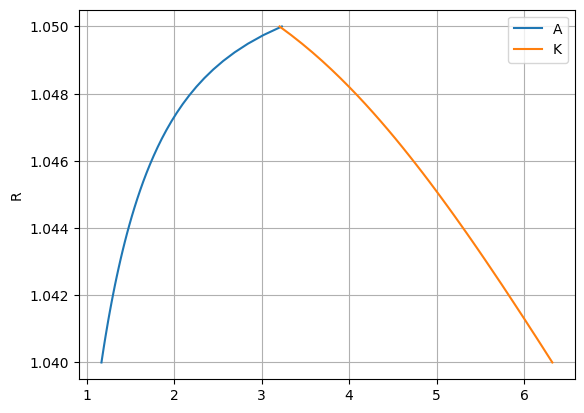

In [79]:
# Plot

plt.plot(Agrid, Rgrid, label='A')
plt.plot(Kgrid, Rgrid, label='K')
plt.ylabel('R')
plt.legend()
plt.grid()
plt.show()

As one can see from the plot, the the stationary general equilibrium is given at R close to 1.050. 